# 📊 Phân Tích Chuyên Sâu Kết Quả K-means - Phát Hiện Rửa Tiền

**Dự án:** Phân tích giao dịch HI-Large  
**Dữ liệu:** 179 triệu giao dịch  
**Phương pháp:** MLlib K-means (k-means++) với Apache Spark + Polars  
**Pipeline:** `full_pipeline_spark_v2.sh`

---

## 📑 Mục Lục

1. [Setup & Import](#1)
2. [Tìm Snapshot Mới Nhất](#2)
3. [Đọc & Phân Tích Dữ Liệu Cluster](#3)
4. [Biểu Đồ Phân Phối Cụm](#4)
5. [Phân Tích Rửa Tiền](#5)
6. [Phân Tích Centroids (Tâm Cụm)](#6)
7. [So Sánh Đặc Trưng Giữa Các Cụm](#7)
8. [Phân Tích Mối Tương Quan](#8)
9. [Phân Tích Loại Tiền Tệ](#9)
10. [Tỷ Lệ Rủi Ro Chi Tiết](#10)
11. [Kết Luận & Khuyến Nghị](#11)

<a id="1"></a>
## 1. ⚙️ Setup & Import Thư Viện

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Cấu hình
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.options.display.float_format = '{:.2f}'.format

# Tên các đặc trưng (theo thứ tự trong centroids)
FEATURE_NAMES = [
    'amount_received',
    'amount_paid', 
    'amount_ratio',
    'hour',
    'day_of_week',
    'route_hash',
    'recv_curr_encoded',
    'payment_curr_encoded',
    'payment_format_encoded'
]

print("✅ Đã import thư viện thành công!")

✅ Đã import thư viện thành công!


<a id="2"></a>
## 2. 📂 Tìm Snapshot Mới Nhất

In [ ]:
# Đường dẫn
ROOT = Path.cwd().parent if 'visualizations' in str(Path.cwd()) else Path.cwd()
DATA_RAW = ROOT / 'data' / 'raw' / 'HI-Large_Trans.csv'
SNAPSHOTS_DIR = ROOT / 'snapshots'

# Tìm snapshot mới nhất
snapshots = sorted([d for d in SNAPSHOTS_DIR.iterdir() if d.is_dir()], reverse=True)

if not snapshots:
    raise FileNotFoundError("❌ Không tìm thấy snapshot nào. Hãy chạy pipeline trước!")

latest_snapshot = snapshots[0]
print(f"📂 Snapshot mới nhất: {latest_snapshot.name}")

# Đọc metadata
metadata_file = latest_snapshot / 'metadata.json'
with open(metadata_file) as f:
    metadata = json.load(f)

print(f"🕐 Thời gian: {metadata['datetime']}")
print(f"📊 Tổng kích thước: {metadata['total_size_mb']:.2f} MB")
print(f"\n📄 Files trong snapshot:")
for file_info in metadata['files']:
    print(f"  - {file_info['name']}: {file_info['size_mb']:.2f} MB")

📂 Snapshot mới nhất: snapshot_20251029_213229
🕐 Thời gian: 2025-10-29T21:32:30.094963
📊 Tổng kích thước: 342.75 MB

📄 Files trong snapshot:
  - final_centroids.txt: 0.00 MB
  - clustered_results.txt: 342.75 MB
  - suspicious_transactions.csv: 0.00 MB


<a id="3"></a>
## 3. 📊 Đọc & Phân Tích Dữ Liệu Cluster

In [3]:
# Đọc kết quả phân cụm
clusters_file = latest_snapshot / 'clustered_results.txt'
print(f"Đang đọc: {clusters_file}")

clusters = np.loadtxt(clusters_file, dtype=int)

print(f"✅ Đã tải {len(clusters):,} nhãn cụm")
print(f"Số cụm: {np.unique(clusters).size}")

# Đếm phân phối
unique, counts = np.unique(clusters, return_counts=True)
cluster_distribution = dict(zip(unique, counts))

print(f"\n📊 Phân phối cụm:")
for cluster_id, count in sorted(cluster_distribution.items()):
    percentage = (count / len(clusters)) * 100
    bar = '█' * int(percentage / 2)
    print(f"  Cụm {cluster_id}: {count:>12,} ({percentage:>6.2f}%) {bar}")

Đang đọc: /home/ultimatebrok/Downloads/Final/05_snapshots/snapshot_20251029_213229/clustered_results.txt
✅ Đã tải 179,702,229 nhãn cụm
Số cụm: 5

📊 Phân phối cụm:
  Cụm 0:   36,926,395 ( 20.55%) ██████████
  Cụm 1:   69,939,082 ( 38.92%) ███████████████████
  Cụm 2:   68,931,713 ( 38.36%) ███████████████████
  Cụm 3:           18 (  0.00%) 
  Cụm 4:    3,905,021 (  2.17%) █


<a id="4"></a>
## 4. 📈 Biểu Đồ Phân Phối Cụm

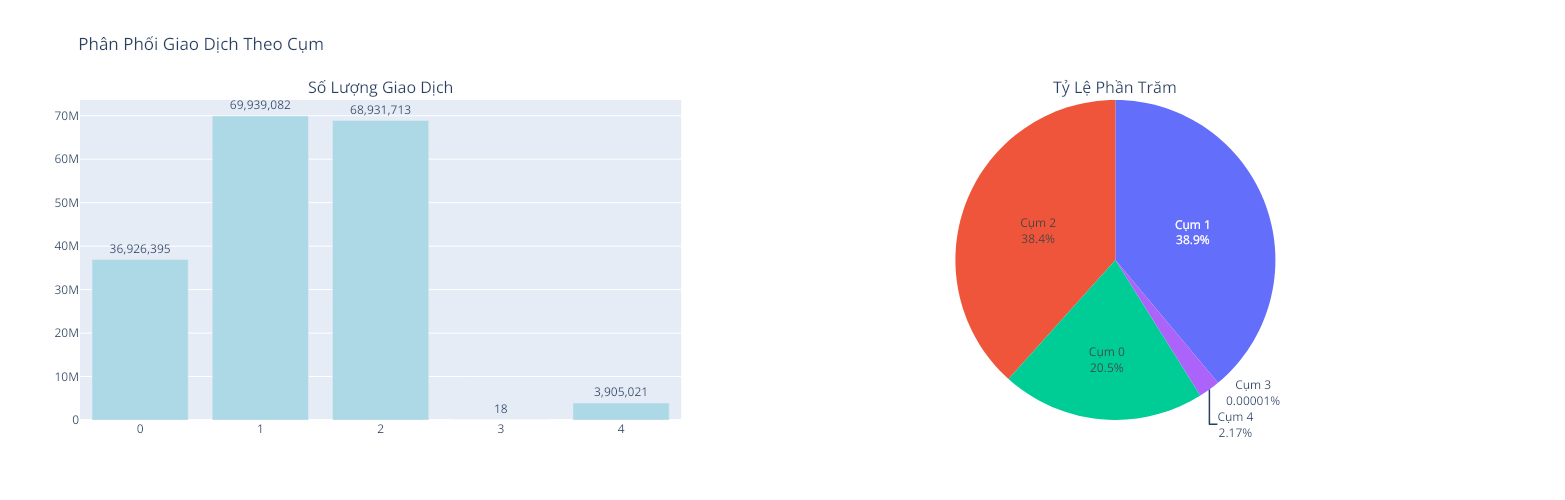

In [4]:
# Tạo DataFrame
cluster_df = pl.DataFrame({
    'cluster': list(cluster_distribution.keys()),
    'count': list(cluster_distribution.values())
}).with_columns(
    (pl.col('count') / len(clusters) * 100).alias('percentage')
).sort('cluster')

# Biểu đồ phân phối
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "bar"}, {"type": "pie"}]],
    subplot_titles=("Số Lượng Giao Dịch", "Tỷ Lệ Phần Trăm")
)

# Bar chart
fig.add_trace(
    go.Bar(
        x=cluster_df['cluster'].to_list(),
        y=cluster_df['count'].to_list(),
        text=cluster_df['count'].to_list(),
        texttemplate='%{text:,.0f}',
        textposition='outside',
        marker_color='lightblue',
        name='Số lượng'
    ),
    row=1, col=1
)

# Pie chart
fig.add_trace(
    go.Pie(
        labels=[f'Cụm {i}' for i in cluster_df['cluster'].to_list()],
        values=cluster_df['count'].to_list(),
        textinfo='label+percent',
        name='Phân phối'
    ),
    row=1, col=2
)

fig.update_layout(height=500, showlegend=False, title_text="Phân Phối Giao Dịch Theo Cụm")
fig.show()

<a id="5"></a>
## 5. 💰 Phân Tích Rửa Tiền

In [5]:
print("⏳ Đang phân tích rửa tiền với Lazy Loading...")
print("Lưu ý: Quá trình này có thể mất vài phút\n")

# Dùng scan_csv (lazy)
df_lazy = pl.scan_csv(DATA_RAW)

# Thêm cột cluster
df_lazy = df_lazy.with_columns(
    pl.Series('cluster', clusters).alias('cluster')
)

# Tính toán thống kê rửa tiền
laundering_stats = df_lazy.group_by('cluster').agg([
    pl.len().alias('total'),
    pl.col('Is Laundering').sum().alias('laundering_count'),
    (pl.col('Is Laundering').sum() / pl.len() * 100).alias('laundering_rate')
]).sort('cluster').collect()

# Tính toán đặc trưng trung bình theo cụm
cluster_features = df_lazy.group_by('cluster').agg([
    pl.col('Amount Received').mean().alias('avg_amount_received'),
    pl.col('Amount Paid').mean().alias('avg_amount_paid'),
    (pl.col('Amount Received') / pl.col('Amount Paid')).mean().alias('avg_ratio')
]).sort('cluster').collect()

print("✅ Hoàn tất phân tích!\n")
print(laundering_stats)
print("\n" + "="*70)
print(cluster_features)

⏳ Đang phân tích rửa tiền với Lazy Loading...
Lưu ý: Quá trình này có thể mất vài phút

✅ Hoàn tất phân tích!

shape: (5, 4)
┌─────────┬──────────┬──────────────────┬─────────────────┐
│ cluster ┆ total    ┆ laundering_count ┆ laundering_rate │
│ ---     ┆ ---      ┆ ---              ┆ ---             │
│ i64     ┆ u32      ┆ i64              ┆ f64             │
╞═════════╪══════════╪══════════════════╪═════════════════╡
│ 0       ┆ 36926395 ┆ 29920            ┆ 0.081026        │
│ 1       ┆ 69939082 ┆ 78960            ┆ 0.112898        │
│ 2       ┆ 68931713 ┆ 115057           ┆ 0.166914        │
│ 3       ┆ 18       ┆ 1                ┆ 5.555556        │
│ 4       ┆ 3905021  ┆ 1608             ┆ 0.041178        │
└─────────┴──────────┴──────────────────┴─────────────────┘

shape: (5, 4)
┌─────────┬─────────────────────┬─────────────────┬───────────┐
│ cluster ┆ avg_amount_received ┆ avg_amount_paid ┆ avg_ratio │
│ ---     ┆ ---                 ┆ ---             ┆ ---       │
│ i64   

<a id="6"></a>
## 6. 🎯 Phân Tích Centroids (Tâm Cụm)

✅ Đã tải 5 tâm cụm, mỗi tâm có 9 đặc trưng

📊 Giá trị các đặc trưng tại tâm cụm:
     amount_received  amount_paid  amount_ratio  hour  day_of_week  route_hash  recv_curr_encoded  payment_curr_encoded  payment_format_encoded
Cụm                                                                                                                                            
0               0.00         0.00         -0.00 -0.00        -0.00        0.01               1.67                  1.67                    0.12
1              -0.00        -0.00          0.00 -0.87         0.01       -0.11              -0.44                 -0.44                    0.08
2              -0.00        -0.00         -0.00  0.88        -0.01        0.11              -0.44                 -0.44                    0.16
3            2334.80      2056.51          0.02 -0.53         0.08       -0.49               0.57                  0.26                    0.56
4              -0.00        -0.00         -0.00  0.00  

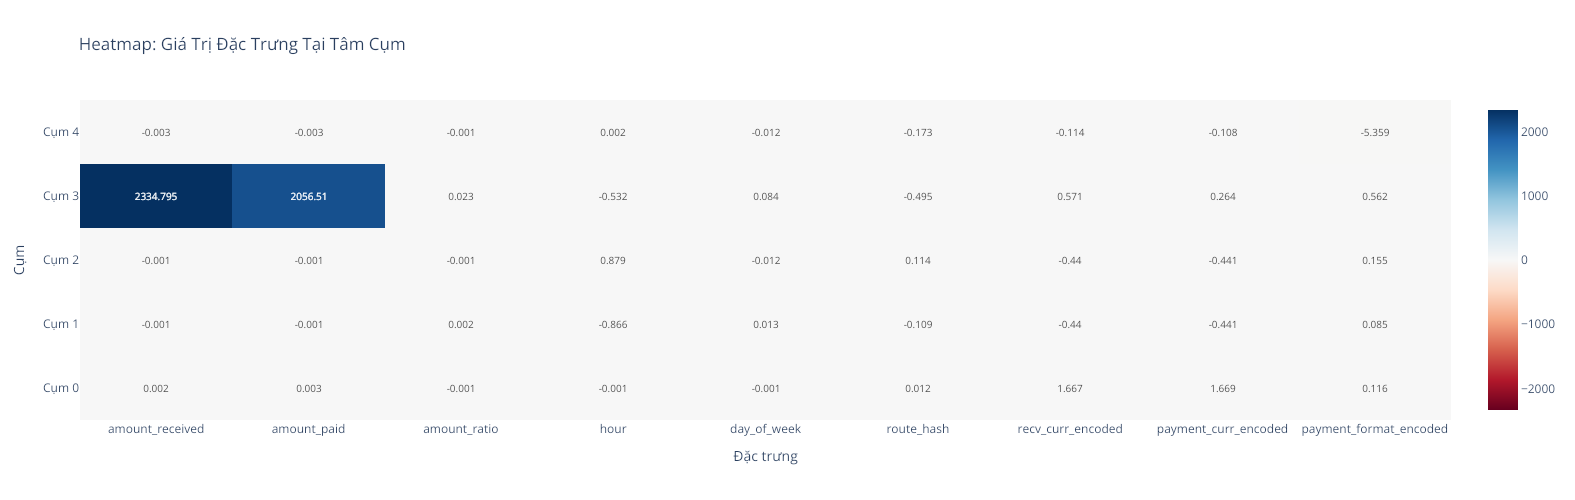

In [6]:
# Đọc centroids
centroids_file = latest_snapshot / 'final_centroids.txt'
centroids = np.loadtxt(centroids_file, delimiter=',')

print(f"✅ Đã tải {len(centroids)} tâm cụm, mỗi tâm có {centroids.shape[1]} đặc trưng\n")

# Tạo DataFrame cho centroids
centroids_df = pd.DataFrame(centroids, columns=FEATURE_NAMES)
centroids_df.index.name = 'Cụm'

print("📊 Giá trị các đặc trưng tại tâm cụm:")
print(centroids_df.to_string())

# Heatmap centroids
fig = go.Figure(data=go.Heatmap(
    z=centroids_df.values,
    x=FEATURE_NAMES,
    y=[f'Cụm {i}' for i in range(len(centroids))],
    colorscale='RdBu',
    zmid=0,
    text=np.round(centroids_df.values, 3),
    texttemplate='%{text}',
    textfont={"size": 10}
))

fig.update_layout(
    title='Heatmap: Giá Trị Đặc Trưng Tại Tâm Cụm',
    xaxis_title='Đặc trưng',
    yaxis_title='Cụm',
    height=500
)
fig.show()

<a id="7"></a>
## 7. 📊 So Sánh Đặc Trưng Giữa Các Cụm

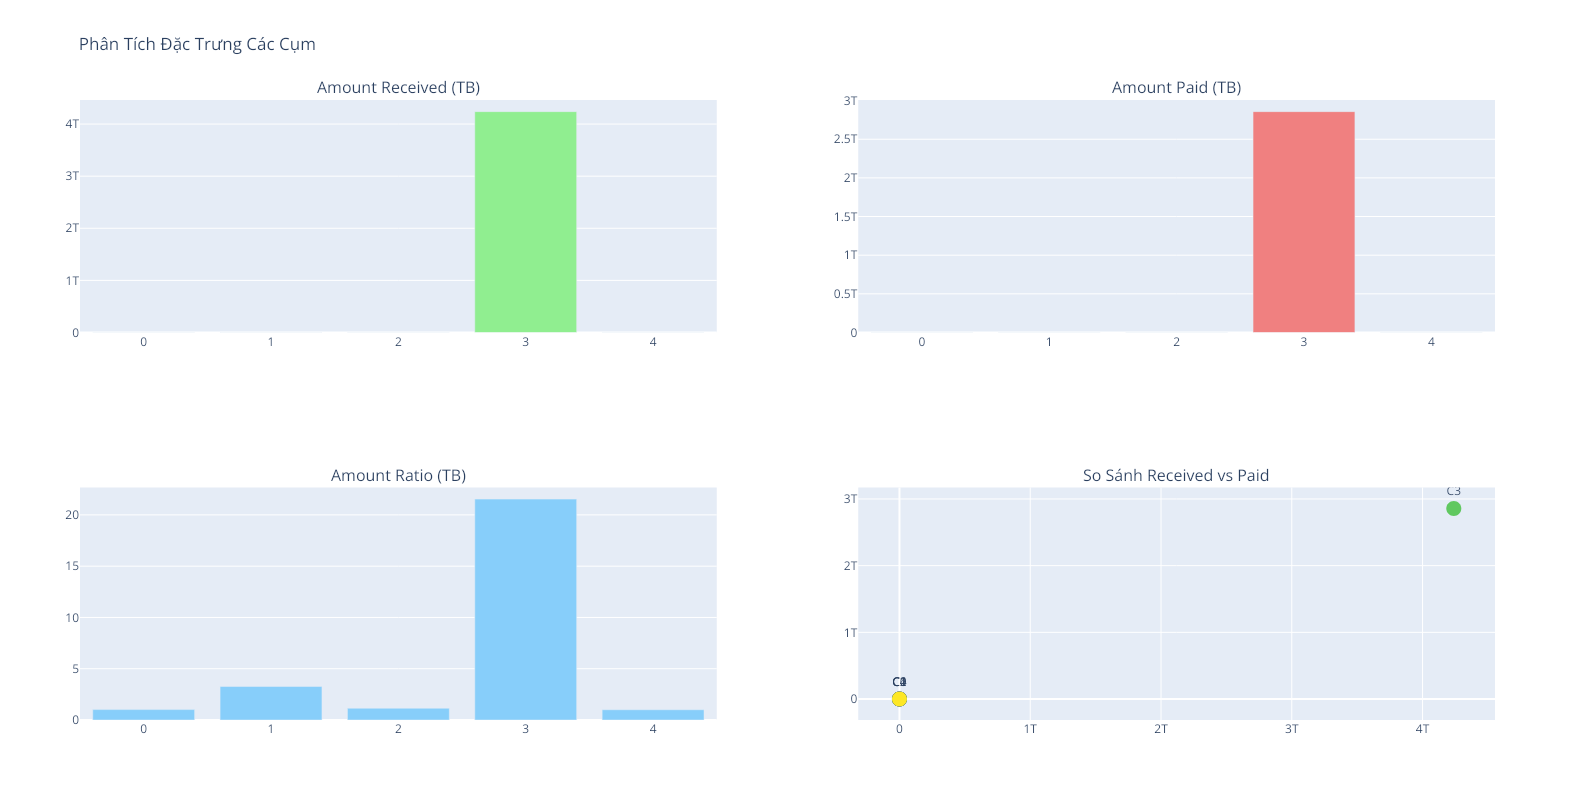

In [7]:
# So sánh amount_received và amount_paid
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Amount Received (TB)',
        'Amount Paid (TB)',
        'Amount Ratio (TB)',
        'So Sánh Received vs Paid'
    ),
    specs=[[{"type": "bar"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "scatter"}]]
)

cluster_feat_pd = cluster_features.to_pandas()

# Amount Received
fig.add_trace(
    go.Bar(x=cluster_feat_pd['cluster'], y=cluster_feat_pd['avg_amount_received'],
           name='Received', marker_color='lightgreen'),
    row=1, col=1
)

# Amount Paid
fig.add_trace(
    go.Bar(x=cluster_feat_pd['cluster'], y=cluster_feat_pd['avg_amount_paid'],
           name='Paid', marker_color='lightcoral'),
    row=1, col=2
)

# Ratio
fig.add_trace(
    go.Bar(x=cluster_feat_pd['cluster'], y=cluster_feat_pd['avg_ratio'],
           name='Ratio', marker_color='lightskyblue'),
    row=2, col=1
)

# Scatter: Received vs Paid
fig.add_trace(
    go.Scatter(
        x=cluster_feat_pd['avg_amount_received'],
        y=cluster_feat_pd['avg_amount_paid'],
        mode='markers+text',
        text=[f'C{i}' for i in cluster_feat_pd['cluster']],
        textposition='top center',
        marker=dict(size=15, color=cluster_feat_pd['cluster'], colorscale='Viridis'),
        name='Cụm'
    ),
    row=2, col=2
)

fig.update_layout(height=800, showlegend=False, title_text="Phân Tích Đặc Trưng Các Cụm")
fig.show()

<a id="8"></a>
## 8. 🔗 Phân Tích Mối Tương Quan

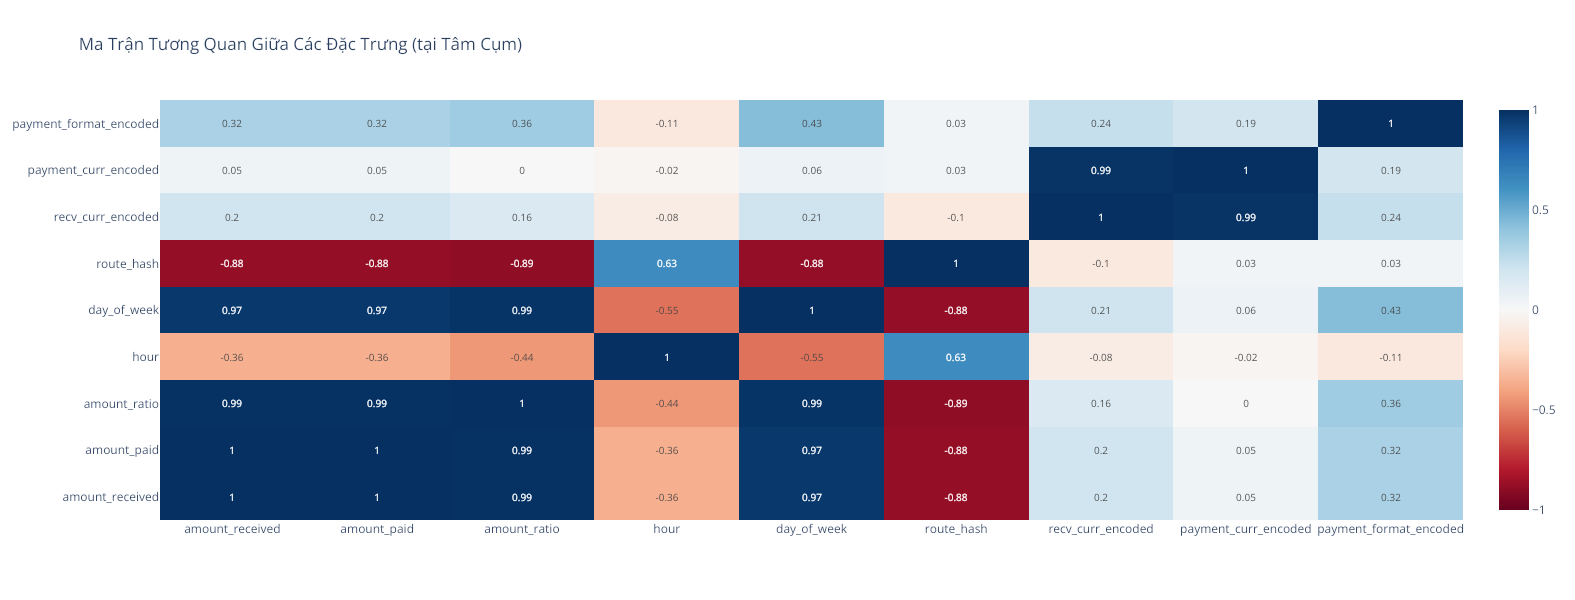


📊 Top 5 cặp đặc trưng tương quan cao nhất:
        Feature 1            Feature 2  Correlation
  amount_received          amount_paid         1.00
  amount_received         amount_ratio         0.99
      amount_paid         amount_ratio         0.99
recv_curr_encoded payment_curr_encoded         0.99
     amount_ratio          day_of_week         0.99


In [8]:
# Tính correlation matrix cho centroids
corr_matrix = centroids_df.corr()

fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=FEATURE_NAMES,
    y=FEATURE_NAMES,
    colorscale='RdBu',
    zmid=0,
    text=np.round(corr_matrix.values, 2),
    texttemplate='%{text}',
    textfont={"size": 10}
))

fig.update_layout(
    title='Ma Trận Tương Quan Giữa Các Đặc Trưng (tại Tâm Cụm)',
    height=600
)
fig.show()

print("\n📊 Top 5 cặp đặc trưng tương quan cao nhất:")
corr_pairs = []
for i in range(len(FEATURE_NAMES)):
    for j in range(i+1, len(FEATURE_NAMES)):
        corr_pairs.append({
            'Feature 1': FEATURE_NAMES[i],
            'Feature 2': FEATURE_NAMES[j],
            'Correlation': corr_matrix.values[i, j]
        })

corr_df = pd.DataFrame(corr_pairs).sort_values('Correlation', ascending=False)
print(corr_df.head(5).to_string(index=False))

<a id="9"></a>
## 9. 💱 Phân Tích Loại Tiền Tệ

In [9]:
print("⏳ Đang phân tích phân phối loại tiền tệ theo cụm...\n")

# Phân tích top currencies theo cụm
currency_analysis = df_lazy.group_by(['cluster', 'Receiving Currency']).agg([
    pl.len().alias('count')
]).sort(['cluster', 'count'], descending=[False, True]).collect()

# Top 5 currencies cho mỗi cụm
print("📊 Top 5 loại tiền phổ biến nhất trong mỗi cụm:\n")
for cluster_id in sorted(cluster_distribution.keys()):
    cluster_curr = currency_analysis.filter(pl.col('cluster') == cluster_id).head(5)
    print(f"\n🔹 Cụm {cluster_id}:")
    for row in cluster_curr.iter_rows(named=True):
        pct = (row['count'] / cluster_distribution[cluster_id]) * 100
        print(f"  - {row['Receiving Currency']}: {row['count']:,} ({pct:.2f}%)")

⏳ Đang phân tích phân phối loại tiền tệ theo cụm...

📊 Top 5 loại tiền phổ biến nhất trong mỗi cụm:


🔹 Cụm 0:
  - Shekel: 7,942,689 (21.51%)
  - Ruble: 5,484,540 (14.85%)
  - Australian Dollar: 5,144,373 (13.93%)
  - Swiss Franc: 4,829,029 (13.08%)
  - Mexican Peso: 4,736,812 (12.83%)

🔹 Cụm 1:
  - US Dollar: 32,838,340 (46.95%)
  - Euro: 20,828,332 (29.78%)
  - Yuan: 6,503,888 (9.30%)
  - Canadian Dollar: 3,095,692 (4.43%)
  - UK Pound: 2,892,182 (4.14%)

🔹 Cụm 2:
  - US Dollar: 32,448,619 (47.07%)
  - Euro: 20,458,940 (29.68%)
  - Yuan: 6,414,944 (9.31%)
  - Canadian Dollar: 3,043,278 (4.41%)
  - UK Pound: 2,856,511 (4.14%)

🔹 Cụm 3:
  - Ruble: 8 (44.44%)
  - Yen: 7 (38.89%)
  - Rupee: 2 (11.11%)
  - Euro: 1 (5.56%)

🔹 Cụm 4:
  - Bitcoin: 3,903,065 (99.95%)
  - US Dollar: 825 (0.02%)
  - Euro: 363 (0.01%)
  - Canadian Dollar: 188 (0.00%)
  - Shekel: 115 (0.00%)


<a id="10"></a>
## 10. ⚠️ Tỷ Lệ Rủi Ro Chi Tiết

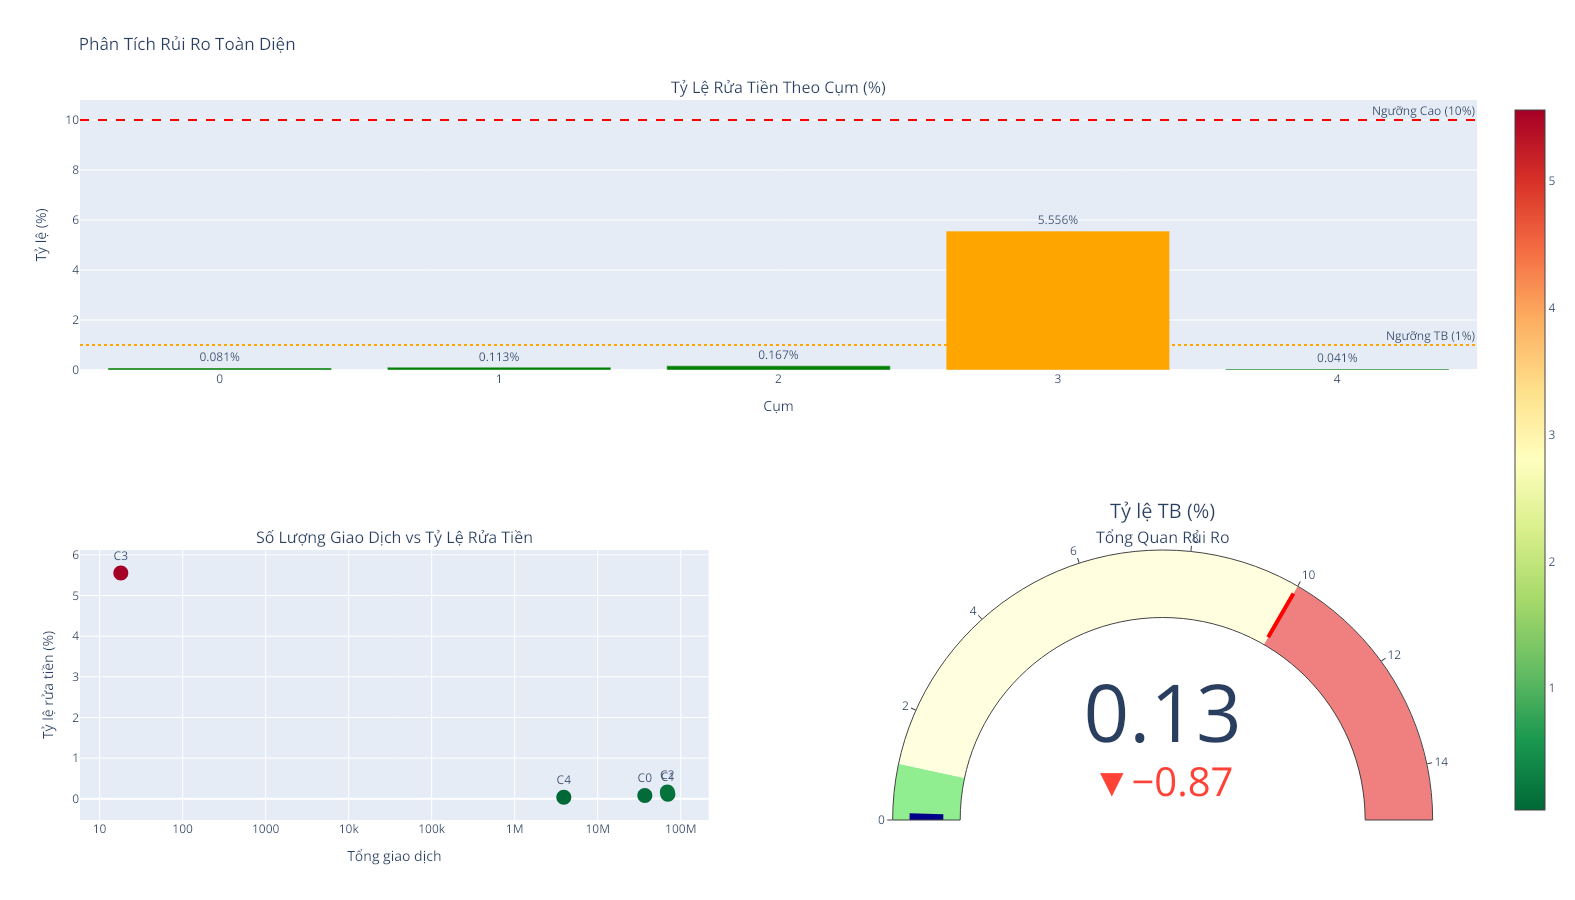

In [10]:
# Biểu đồ tỷ lệ rửa tiền với nhiều góc nhìn
launder_df = laundering_stats.to_pandas()

fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"type": "bar", "colspan": 2}, None],
           [{"type": "scatter"}, {"type": "indicator"}]],
    subplot_titles=(
        'Tỷ Lệ Rửa Tiền Theo Cụm (%)',
        'Số Lượng Giao Dịch vs Tỷ Lệ Rửa Tiền',
        'Tổng Quan Rủi Ro'
    )
)

# Bar chart với màu sắc theo mức độ nguy hiểm
colors = ['green' if r < 1 else 'orange' if r < 10 else 'red' 
          for r in launder_df['laundering_rate']]

fig.add_trace(
    go.Bar(
        x=launder_df['cluster'],
        y=launder_df['laundering_rate'],
        text=launder_df['laundering_rate'].apply(lambda x: f"{x:.3f}%"),
        textposition='outside',
        marker_color=colors,
        name='Tỷ lệ'
    ),
    row=1, col=1
)

# Thêm ngưỡng
fig.add_hline(y=10, line_dash="dash", line_color="red", 
              annotation_text="Ngưỡng Cao (10%)", row=1, col=1)
fig.add_hline(y=1, line_dash="dot", line_color="orange",
              annotation_text="Ngưỡng TB (1%)", row=1, col=1)

# Scatter: Total vs Rate
fig.add_trace(
    go.Scatter(
        x=launder_df['total'],
        y=launder_df['laundering_rate'],
        mode='markers+text',
        text=[f'C{i}' for i in launder_df['cluster']],
        textposition='top center',
        marker=dict(size=15, color=launder_df['laundering_rate'], 
                   colorscale='RdYlGn_r', showscale=True),
        name='Cụm'
    ),
    row=2, col=1
)

# Indicator: Overall risk
high_risk_count = len(launder_df[launder_df['laundering_rate'] >= 10])
overall_rate = launder_df['laundering_count'].sum() / launder_df['total'].sum() * 100

fig.add_trace(
    go.Indicator(
        mode="gauge+number+delta",
        value=overall_rate,
        title={'text': "Tỷ lệ TB (%)"},
        delta={'reference': 1.0},
        gauge={
            'axis': {'range': [0, 15]},
            'bar': {'color': "darkblue"},
            'steps': [
                {'range': [0, 1], 'color': "lightgreen"},
                {'range': [1, 10], 'color': "lightyellow"},
                {'range': [10, 15], 'color': "lightcoral"}],
            'threshold': {
                'line': {'color': "red", 'width': 4},
                'thickness': 0.75,
                'value': 10}
        }
    ),
    row=2, col=2
)

fig.update_xaxes(title_text="Cụm", row=1, col=1)
fig.update_yaxes(title_text="Tỷ lệ (%)", row=1, col=1)
fig.update_xaxes(title_text="Tổng giao dịch", type="log", row=2, col=1)
fig.update_yaxes(title_text="Tỷ lệ rửa tiền (%)", row=2, col=1)

fig.update_layout(height=900, showlegend=False, title_text="Phân Tích Rủi Ro Toàn Diện")
fig.show()

<a id="11"></a>
## 11. 📝 Kết Luận & Khuyến Nghị

In [11]:
print("="*70)
print("KẾT LUẬN & KHUYẾN NGHỊ")
print("="*70)

# Thống kê tổng thể
total_transactions = len(clusters)
total_laundering = laundering_stats['laundering_count'].sum()
overall_rate = (total_laundering / total_transactions) * 100

print(f"\n📊 THỐNG KÊ TỔNG QUÁT:")
print(f"  ├─ Tổng giao dịch: {total_transactions:,}")
print(f"  ├─ Giao dịch rửa tiền: {total_laundering:,}")
print(f"  ├─ Tỷ lệ trung bình: {overall_rate:.4f}%")
print(f"  └─ Số cụm: {np.unique(clusters).size}")

# Phân loại cụm
high_risk = laundering_stats.filter(pl.col('laundering_rate') >= 10.0)
medium_risk = laundering_stats.filter(
    (pl.col('laundering_rate') >= 1.0) & (pl.col('laundering_rate') < 10.0)
)
low_risk = laundering_stats.filter(pl.col('laundering_rate') < 1.0)

print(f"\n🎯 PHÂN LOẠI RỦI RO:")
print(f"  ├─ 🔴 Rủi ro CAO (≥10%): {len(high_risk)} cụm")
if len(high_risk) > 0:
    for row in high_risk.iter_rows(named=True):
        print(f"  │  └─ Cụm {row['cluster']}: {row['laundering_rate']:.3f}% ({row['total']:,} GD)")
        
print(f"  ├─ 🟡 Rủi ro TRUNG BÌNH (1-10%): {len(medium_risk)} cụm")
if len(medium_risk) > 0:
    for row in medium_risk.iter_rows(named=True):
        print(f"  │  └─ Cụm {row['cluster']}: {row['laundering_rate']:.3f}% ({row['total']:,} GD)")
        
print(f"  └─ 🟢 Rủi ro THẤP (<1%): {len(low_risk)} cụm")
if len(low_risk) > 0:
    for row in low_risk.iter_rows(named=True):
        print(f"     └─ Cụm {row['cluster']}: {row['laundering_rate']:.3f}% ({row['total']:,} GD)")

# Cụm outlier
print(f"\n⚠️  CỤM BẤT THƯỜNG (OUTLIER):")
for cluster_id, count in cluster_distribution.items():
    if count < 100:
        rate = laundering_stats.filter(pl.col('cluster') == cluster_id)['laundering_rate'][0]
        print(f"  └─ Cụm {cluster_id}: Chỉ {count} GD nhưng tỷ lệ {rate:.2f}%")
        print(f"     → Khuyến nghị: Kiểm tra thủ công từng giao dịch")

# Khuyến nghị
print(f"\n💡 KHUYẾN NGHỊ:")
if len(high_risk) == 0:
    print(f"  ✅ KHÔNG có cụm rủi ro cao (>10%)")
    print(f"  ✅ Hệ thống hoạt động tốt, tiếp tục giám sát định kỳ")
else:
    print(f"  ⚠️  CÓ {len(high_risk)} cụm rủi ro cao cần xem xét ngay")
    print(f"  ⚠️  Ưu tiên kiểm tra các giao dịch trong cụm này")

# Cụm cần theo dõi
watch_clusters = laundering_stats.filter(
    (pl.col('laundering_rate') >= 0.5) & (pl.col('total') >= 1000)
)
print(f"\n👁️  CỤM CẦN THEO DÕI (≥0.5% và ≥1000 GD):")
for row in watch_clusters.iter_rows(named=True):
    print(f"  └─ Cụm {row['cluster']}: {row['laundering_rate']:.3f}% ({row['total']:,} GD)")

print("\n" + "="*70)
print(f"📅 Phân tích hoàn tất: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📁 Snapshot: {latest_snapshot.name}")
print("="*70)

KẾT LUẬN & KHUYẾN NGHỊ

📊 THỐNG KÊ TỔNG QUÁT:
  ├─ Tổng giao dịch: 179,702,229
  ├─ Giao dịch rửa tiền: 225,546
  ├─ Tỷ lệ trung bình: 0.1255%
  └─ Số cụm: 5

🎯 PHÂN LOẠI RỦI RO:
  ├─ 🔴 Rủi ro CAO (≥10%): 0 cụm
  ├─ 🟡 Rủi ro TRUNG BÌNH (1-10%): 1 cụm
  │  └─ Cụm 3: 5.556% (18 GD)
  └─ 🟢 Rủi ro THẤP (<1%): 4 cụm
     └─ Cụm 0: 0.081% (36,926,395 GD)
     └─ Cụm 1: 0.113% (69,939,082 GD)
     └─ Cụm 2: 0.167% (68,931,713 GD)
     └─ Cụm 4: 0.041% (3,905,021 GD)

⚠️  CỤM BẤT THƯỜNG (OUTLIER):
  └─ Cụm 3: Chỉ 18 GD nhưng tỷ lệ 5.56%
     → Khuyến nghị: Kiểm tra thủ công từng giao dịch

💡 KHUYẾN NGHỊ:
  ✅ KHÔNG có cụm rủi ro cao (>10%)
  ✅ Hệ thống hoạt động tốt, tiếp tục giám sát định kỳ

👁️  CỤM CẦN THEO DÕI (≥0.5% và ≥1000 GD):

📅 Phân tích hoàn tất: 2025-10-29 21:33:29
📁 Snapshot: snapshot_20251029_213229
